# Organizing Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
gold = pd.read_csv('LBMA-GOLD.csv')
bitcoin = pd.read_csv('BCHAIN-MKPRU.csv')

In [ ]:
gpc = []
for i in gold.index:
    gpc.append(round((gold['USD (PM)'].iloc[i] - gold['USD (PM)'].iloc[i - 1]) / 100, 2))
    
gold['Gold_%'] = gpc
gold.at[0, 'Gold_%'] = 0

gold = gold.rename(columns = {'USD (PM)' : 'value'})

gold = gold.ffill()

In [ ]:
bpc = []
for i in bitcoin.index:
    bpc.append(round((bitcoin['Value'].iloc[i] - bitcoin['Value'].iloc[i - 1]) / 100, 2))
    
bitcoin['Bitcoin_%'] = bpc
bitcoin.at[0, 'Bitcoin_%'] = 0

bitcoin

,Date,Value,Bitcoin_%
0,9/11/16,621.65,0.00
1,9/12/16,609.67,-0.12
2,9/13/16,610.92,0.01
3,9/14/16,608.82,-0.02
4,9/15/16,610.38,0.02
...,...,...,...
1821,9/6/21,51769.06,18.22
1822,9/7/21,52677.40,9.08
1823,9/8/21,46809.17,-58.68
1824,9/9/21,46078.38,-7.31


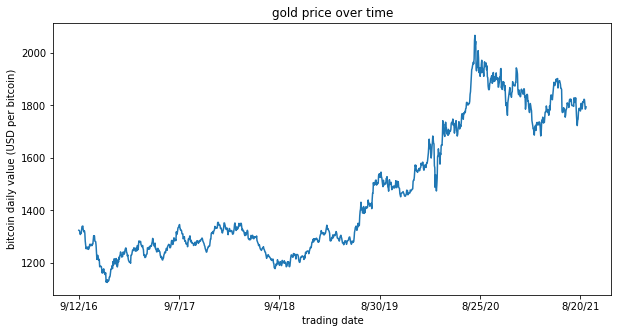

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(gold['Date'], gold['value'])

plt.xticks(gold['Date'][::250])
plt.title('gold price over time')
plt.ylabel('bitcoin daily value (USD per bitcoin)')
plt.xlabel('trading date')
plt.show()

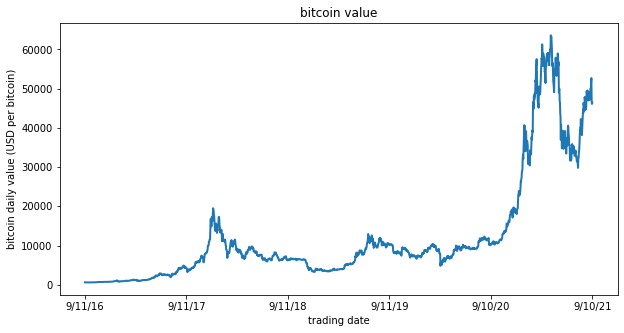

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(bitcoin['Date'], bitcoin['Value'], linewidth = 2)

plt.xticks(bitcoin['Date'][::365])
plt.title('bitcoin value')
plt.ylabel('bitcoin daily value (USD per bitcoin)')
plt.xlabel('trading date')
plt.show()

In [ ]:
assets = bitcoin.merge(gold, how = 'left', left_on = 'Date', right_on = 'Date')
assets.ffill()

assets = assets.rename(columns = {'value' : 'Gold_price', 'Value' : 'Bitcoin_price'})

assets.at[0, 'Gold_price'] = 1324.60
assets.at[0, 'Gold_%'] = 0

assets

,Date,Bitcoin_price,Bitcoin_%,Gold_price,Gold_%
0,9/11/16,621.65,0.00,1324.60,0.00
1,9/12/16,609.67,-0.12,1324.60,0.00
2,9/13/16,610.92,0.01,1323.65,-0.01
3,9/14/16,608.82,-0.02,1321.75,-0.02
4,9/15/16,610.38,0.02,1310.80,-0.11
...,...,...,...,...,...
1821,9/6/21,51769.06,18.22,1821.60,-0.02
1822,9/7/21,52677.40,9.08,1802.15,-0.19
1823,9/8/21,46809.17,-58.68,1786.00,-0.16
1824,9/9/21,46078.38,-7.31,1788.25,0.02


# Helper Functions

In [ ]:
def gold_percent_change(index1, index2):
    return round((assets.iloc[index1].Gold_price - assets.iloc[index2].Gold_price) / 100, 2)

def bitcoin_percent_change(index1, index2):
    return round((assets.iloc[index1].Bitcoin_price - assets.iloc[index2].Bitcoin_price) / 100, 2)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}

In [ ]:
def buy_gold(index, proportion = 1):
    payment = amounts['money'] * proportion
    amounts['commission'] += payment * 0.01
    amounts['gold'] += payment * 0.99 / assets.iloc[index]['Gold_price']
    amounts['money'] -= payment

def sell_gold(index, proportion = 1):
    units = amounts['gold'] * proportion
    amounts['gold'] -= units
    amounts['money'] += units * 0.99 * assets.iloc[index]['Gold_price']
    amounts['commission'] += units * 0.02 * assets.iloc[index]['Gold_price']
    
def buy_bitcoin(index, proportion = 1):
    payment = amounts['money'] * proportion
    amounts['commission'] += payment * 0.02
    amounts['bitcoin'] += payment * 0.98 / assets.iloc[index]['Bitcoin_price']
    amounts['money'] -= payment

def sell_bitcoin(index, proportion = 1):
    units = amounts['bitcoin'] * proportion
    amounts['bitcoin'] -= units
    amounts['money'] += units * 0.98 * assets.iloc[index]['Bitcoin_price']
    amounts['commission'] += units * 0.02 * assets.iloc[index]['Bitcoin_price']

In [ ]:
def amount_value(amounts, index):
    return (amounts['money'] + 
            amounts['gold'] * assets.iloc[index].Gold_price + 
            amounts['bitcoin'] * assets.iloc[index].Bitcoin_price)

# Threshold Method

In [ ]:
threshold_values = []
threshold_points = []
def threshold_bitcoin(df, max_threshold, min_threshold, length):
    flag = 0
    buy_price = 0
    for i in df.index:
        diff = bitcoin_percent_change(i, i - length)
        if diff > max_threshold and flag == 1 and buy_price < df.iloc[:, 1][i]:
            sell_bitcoin(i, 0.2)
            buy_price = 0
            flag = 0
        if diff < min_threshold and flag == 0:
            buy_bitcoin(i, 0.8)
            buy_price = df.iloc[:, 1][i]
            flag = 1 
        threshold_values.append(amount_value(amounts, i))
    return amount_value(amounts, i)

In [ ]:
def threshold_gold(df, max_threshold, min_threshold, length):
    flag = 0
    buy_price = 0
    for i in df.index:
        diff = gold_percent_change(i, i - length)
        if diff > max_threshold and flag == 1 and buy_price < df.iloc[:, 1][i]:
            sell_gold(i, 0.1)
            buy_price = 0
            flag = 0
        if diff < min_threshold and flag == 0:
            buy_gold(i)
            buy_price = df.iloc[:, 1][i]
            flag = 1  
    print(amounts['commission'])
    return amount_value(amounts, i)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
threshold_gold(gold, max_threshold = 5, min_threshold = -0.04, length = 1)

10.0


1234.697267099502

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
threshold_bitcoin(bitcoin, max_threshold = 200, min_threshold = -5, length = 1)

58678.32857717365

# Momentum

In [ ]:
def momentum_gold(df, bail, length, s):
    result = 0
    for i in df.index:
        diff = gold_percent_change(i, i - length)
        if diff < bail:
            sell_gold(i, s)
        else:
            buy_gold(i)
    print(amounts['commission'])
    return amount_value(amounts, i)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
momentum_gold(gold, -0.04, 1, 0.5)

nan


nan

In [ ]:
momentum_values = []
momentum_points = []
def momentum_bitcoin(df, bail, length, s):
    for i in df.index:
        diff = bitcoin_percent_change(i, i - length)
        if diff < bail:
            sell_bitcoin(i, s)
        else:
            buy_bitcoin(i)
        momentum_values.append(amount_value(amounts, i))
    return amount_value(amounts, i)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
momentum_bitcoin(bitcoin, -50, 1, 1)

55582.92202573312

# Simple Moving Average

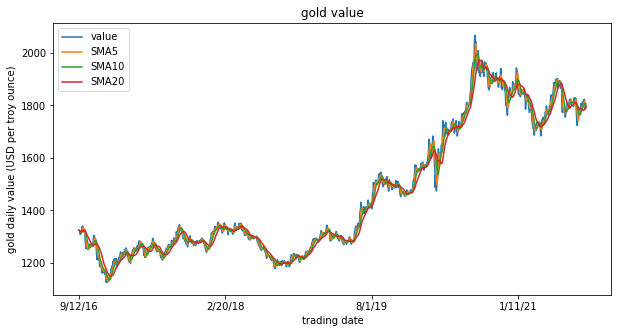

In [ ]:
SMA_gold = pd.DataFrame({'value' : gold['value'],
                   'SMA5' : gold['value'].rolling(5, min_periods = 1).mean(),
                   'SMA10' : gold['value'].rolling(10, min_periods = 1).mean(),
                   'SMA20' : gold['value'].rolling(20, min_periods = 1).mean()})

plt.figure(figsize = (10, 5))

plt.plot(gold['Date'], SMA_gold)

plt.xticks(gold['Date'][::365])
plt.title('gold value')
plt.ylabel('gold daily value (USD per troy ounce)')
plt.xlabel('trading date')
plt.legend(SMA_gold)

plt.show()

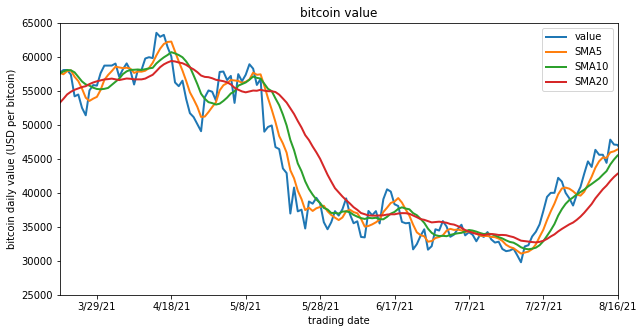

In [ ]:
SMA_bitcoin = pd.DataFrame({'value' : bitcoin['Value'],
                   'SMA5' : bitcoin['Value'].rolling(5, min_periods = 1).mean(),
                   'SMA10' : bitcoin['Value'].rolling(10, min_periods = 1).mean(),
                   'SMA20' : bitcoin['Value'].rolling(20, min_periods = 1).mean()})

plt.figure(figsize = (10, 5))

plt.plot(bitcoin['Date'], SMA_bitcoin, linewidth = 2)

plt.xticks(bitcoin['Date'][::20])
plt.title('bitcoin value')
plt.ylabel('bitcoin daily value (USD per bitcoin)')
plt.xlabel('trading date')
plt.legend(SMA_bitcoin)

plt.xlim(1650, 1800)
plt.ylim(25000, 65000)

plt.show()

In [ ]:
SMA_bit_values = []
SMA_bit_points = []
def simple_moving_average_bitcoin(df, short, long, b, s):
    flag = 0
    buy_price = 0
    for i in df.index:
        if df[short][i] > df[long][i] and flag == 0 :
            buy_bitcoin(i, b)
            buy_price = df.iloc[:, 1][i]
            flag = 1
        elif df[short][i] < df[long][i] and flag == 1 and buy_price < df.iloc[:, 1][i]:
            sell_bitcoin(i, s)
            buy_price = 0
            flag = 0
        SMA_bit_values.append(amount_value(amounts, i))
        SMA_bit_points.append(i)
    return amount_value(amounts, i)

In [ ]:
def simple_moving_average_gold(df, short, long, b, s):
    flag = 0
    buy_price = 0
    for i in df.index:
        if df[short][i] > df[long][i] and flag == 0 :
            buy_gold(i, b)
            flag = 1
        elif df[short][i] < df[long][i] and flag == 1:
            sell_gold(i, s)
            flag = 0
    print(amounts['commission'])
    return amount_value(amounts, i)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
simple_moving_average_gold(SMA_gold, 'SMA5', 'SMA20', 1, 0.1)

nan


nan

In [ ]:
# takes a while to run
bitcoin_best = [0, 0, 0, 0]
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
for b in range(0, 101, 10):
    for s in range(0, 101, 10):
        amounts['money'] = 1000
        amounts['gold'] = 0
        amounts['bitcoin'] = 0
        amounts['commission'] = 0
        final_assets = simple_moving_average_bitcoin(SMA_bitcoin, short = 'SMA5', 
                                                     long = 'SMA20', b = b / 100, s = s / 100)
        if (final_assets > bitcoin_best[0]):
            bitcoin_best[0] = final_assets
            bitcoin_best[1] = b / 100
            bitcoin_best[2] = s / 100
            bitcoin_best[3] = amounts['commission']
bitcoin_best

[73909.9512052308, 1.0, 0.0, 20.0]

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
simple_moving_average_bitcoin(SMA_bitcoin, short = 'SMA5', long = 'SMA20', b = 1, s = 0.05)

68902.25447531993

In [ ]:
SMA_triple_bit_values = []
def SMA_triple_bit(df, Short, Middle, Long, b, s):
    flag_long = False
    flag_short = False
    for i in df.index:
        if df[Middle][i] < df[Long][i] and df[Short][i] < df[Middle][i] and flag_long == False:
            buy_bitcoin(i, b)
            flag_short = True
        elif flag_short == True and df[Short][i] > df[Middle][i]:
            sell_bitcoin(i, s)
            flag_short = False
        elif df[Middle][i] > df[Long][i] and df[Short][i] < df[Middle][i] and flag_long == False:
            buy_bitcoin(i, b)
            flag_short  = True
        elif flag_short == True and df[Short][i] > df[Middle][i]:
            sell_bitcoin(i, s)
            flag_short = False
        else:
            pass    
        SMA_triple_bit_values.append(amount_value(amounts, i))
    return amount_value(amounts, i)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
SMA_triple_bit(SMA_bitcoin, 'SMA5', 'SMA10', 'SMA20', 1, 0.01)

71391.85907548666

## MA Priortization

In [ ]:
priority_values = []
priority_points = []

def bit_ma_prioritization(portfolio, bitcoin_df, max_threshold, min_threshold, length, types):
    if types == 1:
        proportion1 = .75
    elif types == 2:
        proportion1 = .25
    elif types == 3:
        proportion1 = .5
    elif types == 4:
        proportion1 = 1

    proportion2 = 1 - proportion1
    
    p1_amount, p2_amount = 0, 0
    
    flag1, flag2 = 0, 0
    for i in bitcoin_df.index:
        bit_diff = bitcoin_percent_change(i, i - length)
        if bitcoin_df['SMA5'][i] > bitcoin_df['SMA20'][i] and flag1 == 0:
            if p2_amount == 0:
                buy_bitcoin(i, proportion1)
            else:
                buy_bitcoin(i, 1)
            p1_amount = portfolio['bitcoin']
            flag1 = 1
        elif bitcoin_df['SMA5'][i] < bitcoin_df['SMA20'][i] and flag1 == 1:
            if p2_amount == 0:
                sell_bitcoin(i, 1)
            else:
                sell_bitcoin(i, proportion1)
            p1_amount = 0
            flag1 = 0
        
        if bit_diff < min_threshold and flag2 == 0:
            if p1_amount == 0:
                buy_bitcoin(i, proportion2)
            else:
                buy_bitcoin(i, 1)
            p2_amount = portfolio['bitcoin'] - p1_amount
            flag2 = 1
        elif bit_diff > max_threshold and flag2 == 1:
            if p1_amount == 0:
                sell_bitcoin(i, 1)
            else:
                sell_bitcoin(i, proportion2)
            p2_amount = 0
            flag2 = 0
        priority_values.append(amount_value(amounts, i))
        priority_points.append(i)
    return portfolio, amount_value(amounts, i)

In [ ]:
amounts = {'money' : 1000, 'gold' : 0, 'bitcoin' : 0, 'commission' : 0}
bit_ma_prioritization(amounts, SMA_bitcoin, 420, 220, 560, 2)

({'bitcoin': 0.42422466649280643,
  'commission': 10636.085630974734,
  'gold': 0,
  'money': 65700.33419332198},
 85371.07624428031)

## Results

In [ ]:
bit = pd.DataFrame({'bitcoin value' : bitcoin['Value'], 
                    'threshold' : threshold_values, 
                    'momentum' : momentum_values,
                    'SMA' : SMA_bit_values, 
                    'triple SMA' : SMA_triple_bit_values, 
                    'MA Prioritization' : priority_values})

In [ ]:
bit = bit.ffill()

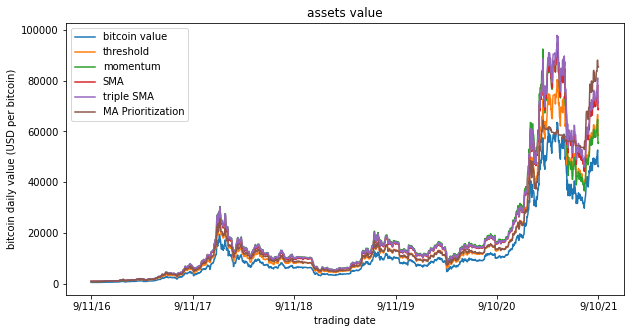

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(bitcoin['Date'], bit)

plt.xticks(bitcoin['Date'][::365])
plt.legend(bit)
plt.title('assets value')
plt.ylabel('bitcoin daily value (USD per bitcoin)')
plt.xlabel('trading date')
plt.show()

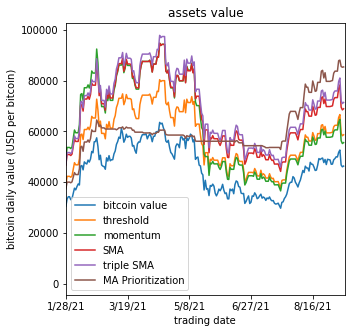

In [ ]:
plt.figure(figsize = (5, 5))

plt.plot(bitcoin['Date'], bit)

plt.xticks(bitcoin['Date'][::50])
plt.legend(bit)
plt.title('assets value')
plt.ylabel('bitcoin daily value (USD per bitcoin)')
plt.xlabel('trading date')
plt.xlim(left = 1600, right = 1826)
plt.show()